# Project 01
## Simple word-counting and TF-IDF semantics

In [24]:
# Load sys to read files
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

import nltk
from nltk.corpus import reuters
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('reuters')

In [31]:
# List downloaded files

# os.listdir('Data/reuters21578/')

After reading the README text, I know that the collection I am interested in is in the 22 sgm files. 
To access these files, I will use `open as infile`. 

There are 6 files describing the categories used to index the data as well.

Opening just one file as an example:

In [4]:
# Open a first file as an example. Used 'r' because it is text mode parsing (read only).
with open('../Data/reuters21578/reut2-008.sgm', 'r', encoding = 'utf-8', errors = 'ignore') as infile:
        data = infile.read()

# To print as a sanity check, uncomment.
#print(data)

Despite the difficult format presentation, the corpus is there. 

I will open all the files in the directory and assemble them in an array called data.

In [8]:
data = []

for i in range(22):
    # Open all filenames. Pad {0} to 3 digits with str methods. 
    # Use range from 0 to 22.
    filename = '../Data/reuters21578/reut2-{0}.sgm'.format(str(i).zfill(3))
    
    # Encoding with most common scheme.
    with open(filename, 'r', encoding = 'utf-8', errors = 'ignore') as infile:
        data.append(infile.read())
        
# Print first 100 characters of the first article
data[0][:600]

'<!DOCTYPE lewis SYSTEM "lewis.dtd">\n<REUTERS TOPICS="YES" LEWISSPLIT="TRAIN" CGISPLIT="TRAINING-SET" OLDID="5544" NEWID="1">\n<DATE>26-FEB-1987 15:01:01.79</DATE>\n<TOPICS><D>cocoa</D></TOPICS>\n<PLACES><D>el-salvador</D><D>usa</D><D>uruguay</D></PLACES>\n<PEOPLE></PEOPLE>\n<ORGS></ORGS>\n<EXCHANGES></EXCHANGES>\n<COMPANIES></COMPANIES>\n<UNKNOWN> \n&#5;&#5;&#5;C T\n&#22;&#22;&#1;f0704&#31;reute\nu f BC-BAHIA-COCOA-REVIEW   02-26 0105</UNKNOWN>\n<TEXT>&#2;\n<TITLE>BAHIA COCOA REVIEW</TITLE>\n<DATELINE>    SALVADOR, Feb 26 - </DATELINE><BODY>Showers continued throughout the week in\nthe Bahia cocoa zone, alle'

All corpora have been set up in an array of arrays. We can see that the text format seems to have a HTML presentation. In order to give some format, I will use BeautifulSoup package.

As a sanity check, I will see what the NLTK package has for 'Reuters' database. 

In [44]:
# nltk.corpus.reuters.raw()

Looks like it is the same database, however the articles are in different order.

Now, I will use BeautifulSoup to parse the text. BeautifulSoup will allow to remove all the HTML tags. There are several ways to do this. I could run a loop and attach an article between the tags of <Body> to a dataframe. (Might do that later - for simplicity now, I will just put it in an array.

In [9]:
from bs4 import BeautifulSoup
example_soup = BeautifulSoup(data[0], 'html.parser')

# print(example_soup.prettify()) # Makes the above easier to read. More as we would see on a describe HTML panel (when scrapping).
# print(example_soup.get_text())  # Removes HTML flags.
# print(example_soup.find_all('body')) # Extracts the text from the HTML tag we choose. This case, the 'Body' tag.

In [10]:
type(example_soup)

bs4.BeautifulSoup

Let's now put all the corpus in the soup. The soup object can just take one index at a time. We need to iterate over our data list.

In [11]:
corpora = []
for text in data:
    # Parse text as html using beautiful soup
    parsed_text = BeautifulSoup(text, 'html.parser')
    table = parsed_text.find_all('body')[0] 
#print(table)

#type(table)

In [12]:
corpora = []
for text in data:
    # Parse text as html using beautiful soup
    parsed_text = BeautifulSoup(text, 'html.parser')
    
    # Extract article between <BODY> and </BODY> and convert to standard text. Add to list of articles
    corpora += [corpora.get_text() for corpora in parsed_text.find_all('body')]

# Print first article as an example
print(corpora[0][:300])

Showers continued throughout the week in
the Bahia cocoa zone, alleviating the drought since early
January and improving prospects for the coming temporao,
although normal humidity levels have not been restored,
Comissaria Smith said in its weekly review.
    The dry period means the temporao will b


In [13]:
# Make Corpora be a DF

df_corpora = pd.DataFrame({'Body': corpora})
df_corpora.head(2)

,Body
0,Showers continued throughout the week in\nthe ...
1,Standard Oil Co and BP North America\nInc said...


## Exploring the Data

Although I have removed some HTML tags, before normalizingthe data, I would still want to remove symbols such as \n or the word Reuter that appears at the end of all articles. This word is not necessary for my analysis. 

Afterwards, I will do a more formal "Normalizing" of the data.

In [17]:
# Option to see the whole column
pd.set_option('display.max_colwidth', -1)

# Removing symbols such as \n, Reuter, and '' that are just showing break lines.
df_corpora = df_corpora.replace('"', '', regex = True)\
                       .replace("\n", ' ', regex = True)\
                       .replace(' Reuter', '', regex = True)

In [18]:
df_corpora.head(1)

,Body
0,"Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since early January and improving prospects for the coming temporao, although normal humidity levels have not been restored, Comissaria Smith said in its weekly review. The dry period means the temporao will be late this year. Arrivals for the week ended February 22 were 155,221 bags of 60 kilos making a cumulative total for the season of 5.93 mln against 5.81 at the same stage last year. Again it seems that cocoa delivered earlier on consignment was included in the arrivals figures. Comissaria Smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has practically come to an end. With total Bahia crop estimates around 6.4 mln bags and sales standing at almost 6.2 mln there are a few hundred thousand bags still in the hands of farmers, middlemen, exporters and processors. There are doubts as to how much of this cocoa would be fit for export as shippers are now experiencing dificulties in obtaining +Bahia superior+ certificates. In view of the lower quality over recent weeks farmers have sold a good part of their cocoa held on consignment. Comissaria Smith said spot bean prices rose to 340 to 350 cruzados per arroba of 15 kilos. Bean shippers were reluctant to offer nearby shipment and only limited sales were booked for March shipment at 1,750 to 1,780 dlrs per tonne to ports to be named. New crop sales were also light and all to open ports with June/July going at 1,850 and 1,880 dlrs and at 35 and 45 dlrs under New York july, Aug/Sept at 1,870, 1,875 and 1,880 dlrs per tonne FOB. Routine sales of butter were made. March/April sold at 4,340, 4,345 and 4,350 dlrs. April/May butter went at 2.27 times New York May, June/July at 4,400 and 4,415 dlrs, Aug/Sept at 4,351 to 4,450 dlrs and at 2.27 and 2.28 times New York Sept and Oct/Dec at 4,480 dlrs and 2.27 times New York Dec, Comissaria Smith said. Destinations were the U.S., Covertible currency areas, Uruguay and open ports. Cake sales were registered at 785 to 995 dlrs for March/April, 785 dlrs for May, 753 dlrs for Aug and 0.39 times New York Dec for Oct/Dec. Buyers were the U.S., Argentina, Uruguay and convertible currency areas. Liquor sales were limited with March/April selling at 2,325 and 2,380 dlrs, June/July at 2,375 dlrs and at 1.25 times New York July, Aug/Sept at 2,400 dlrs and at 1.25 times New York Sept and Oct/Dec at 1.25 times New York Dec, Comissaria Smith said. Total Bahia sales are currently estimated at 6.13 mln bags against the 1986/87 crop and 1.06 mln bags against the 1987/88 crop. Final figures for the period to February 28 are expected to be published by the Brazilian Cocoa Trade Commission after carnival which ends midday on February 27. "


In this first part of the Text Analysis, I want to see, before any text normalization, how many words on average an article has. 

In order to count sentences, I will rely that a sentence finishes with a dot (.) and and it is followed by a space. It is important to note that dots (.) could also be a part of a float number. 

In order to count words, I will split the column "Body" of my data frame and count the length of it. 

For characters, I will take into consdieration the length of the "Body" of an article.

In [19]:
df_corpora['Sentences'] = df_corpora['Body'].str.count('\. ')
df_corpora['Total_Words'] = [len(x.split()) for x in df_corpora['Body'].tolist()]
df_corpora['Total_Char'] = [len(x) for x in df_corpora['Body'].tolist()]

In [20]:
pd.set_option('display.max_colwidth', 100)
df_corpora.head(4)

,Body,Sentences,Total_Words,Total_Char
0,"Showers continued throughout the week in the Bahia cocoa zone, alleviating the drought since ear...",20,487,2854
1,Standard Oil Co and BP North America Inc said they plan to form a venture to manage the money ma...,3,73,432
2,Texas Commerce Bancshares Inc's Texas Commerce Bank-Houston said it filed an application with th...,2,52,324
3,BankAmerica Corp is not under pressure to act quickly on its proposed equity offering and would ...,17,456,2836


Now, I would want to see some statistics regarding my data frame. For example, I want to know on average how many words/sentences/characters an article has.

In [161]:
summary = df_corpora.describe().transpose()
summary[['count', 'mean', '50%', 'min', 'max']]

,count,mean,50%,min,max
Sentences,19043.0,6.058079,4.0,0.0,67.0
Total_Words,19043.0,135.061335,89.0,2.0,1668.0
Total_Char,19043.0,830.272856,548.0,6.0,13391.0


What I find the most interesting is that on average, an article has only 4 sentences. And there are articles that do not even have a sentence. I would want to explore into this a little bit more. 

In [154]:
df_corpora[df_corpora['Sentences'] == 0].count()

Body           1761
Sentences      1761
Total_Words    1761
Total_Char     1761
dtype: int64

1701 articles have 0 sentences. I will look into them and see what kind of articles they could be.

In [22]:
df_corpora[df_corpora['Sentences'] == 0].head(10)

,Body,Sentences,Total_Words,Total_Char
13,Shr one dlr vs 73 cts Net 12.6 mln vs 15.8 mln Revs 337.3 mln vs 315.2 mln Nine mths...,0,39,192
33,Qtly div eights cts vs 7.5 cts prior Pay March 31 Record March 13 ,0,15,76
35,"Shr 45 cts vs 58 cts Net 1.1 mln vs 829,000 Sales 7.9 mln vs 9.4 mln Avg shrs 2,332,...",0,47,249
50,Qtly div 35 cts vs 35 cts prior Payable March 31 Record March nine ,0,15,78
62,"Shr 80 cts vs 72 cts Net 55,513,000 vs 48,741,000 Revs 290.9 mln vs 264.2 mln Year ...",0,39,236
68,Qtly div eights cts vs eight cts prior Pay April one Record March 13 ,0,15,79
79,Qtly div 25 cts vs 25 cts prior Pay April 30 Record April 16 ,0,15,71
80,Qtly div two cts vs 1.7 cts Pay March 26 Record March 12 ,0,14,67
83,Qtly div three cts vs three cts prior Pay March 13 Record February 27 ,0,15,80
89,"Shr profit three cts vs loss three cts Net profit 363,000 vs loss 197,000 Revs 3,761,000...",0,45,268


From the information above, we can see these articles could be talking about dividends or revenues. They are just phrases and most words are in a shortened form.

One way to see what these data is all about would be to go back to the Beautiful soup and allign all data in a data frame, consider titles and article type.

I choose to not remove these articles because although I am currently just exploring the data set, maybe later on, I could use this data to predict what kind of news this article belongs to. 

## Making some plots
I am curious about how the distributions look like, if most articles tend to have more than 10 sentences or if they are usually longer. 

I will plot three histograms to see how Sentences, Words, and Characters manifest their distributions.

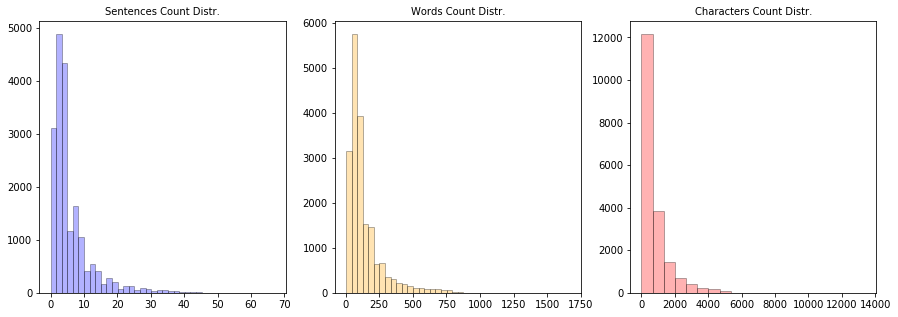

In [58]:
fig, axs = plt.subplots(1, 3, tight_layout = False, figsize = (15,5))

axs[0].hist(df_corpora['Sentences'], color = 'blue', edgecolor = 'black', alpha = 0.3, bins = int(40))
axs[0].set_title('Sentences Count Distr.',fontsize='medium')
axs[1].hist(df_corpora['Total_Words'], color = 'orange', edgecolor = 'black', alpha = 0.3, bins = int(40))
axs[1].set_title('Words Count Distr.',fontsize='medium')
axs[2].hist(df_corpora['Total_Char'], color = 'red', edgecolor = 'black', alpha = 0.3, bins = int(20))
axs[2].set_title('Characters Count Distr.',fontsize='medium')


plt.show()

Out of about 19000 articles, less than 50% have only 4 sentences/89 words/548 characters. I think this is because about 1800 articles were "stock market" articles and these articles are very short and have just shortened words and values. 

## Normalizing the Data

Now, I wonder if I removed stop words, punctuation and changed my vocabulary to a lemmatized one, how would all these features change. I will have for sure less characters and words. But I would also have no sentences. 

These tasks I can think of as now are: lowering capital letters, removing punctuation signs and digits and changing vocabulary to their lemmas or stems.

In [16]:
# Will need this later
#.replace("\[[0-9]*\]","", regex = True)\

In [16]:
# Dictionary where punctuation is mapped to none.
no_punc = str.maketrans('', '', string.punctuation) 

# Remove punctuation from corpora.
corpora = [corpus.translate(no_punc) for corpus in corpora]

In [17]:
# Lowercase all capital letters.
corpora = [corpus.lower() for corpus in corpora]

In [18]:
# Remove digits from corpora.
corpora = [re.sub(r'\d+', '', corpus) for corpus in corpora]
 
# Set English and identified/additional stopwords in order to remove them.
stopwords = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03', '``','’', '`','br','"',"”", "''", "'s", "\\n"])
corpora = [[word for word in corpus.split() if word not in stopwords] for corpus in corpora]

In [19]:
corpora[0][:10]

['showers',
 'continued',
 'throughout',
 'week',
 'bahia',
 'cocoa',
 'zone',
 'alleviating',
 'drought',
 'since']

In [15]:
example = wnl.lemmatize('continued')
example

'continued'

In [14]:
# Change the corpora's full words for just the lemmas
wnl = WordNetLemmatizer()
corpora_lem = [" ".join([wnl.lemmatize(word) for word in corpus]) for corpus in corpora]
# print the first article as a running example
print(corpora_lem[0])

shower continued throughout week bahia cocoa zone alleviating drought since early january improving prospect coming temporao although normal humidity level restored comissaria smith said weekly review dry period mean temporao late year arrival week ended february bag kilo making cumulative total season mln stage last year seems cocoa delivered earlier consignment included arrival figure comissaria smith said still doubt much old crop cocoa still available harvesting practically come end total bahia crop estimate around mln bag sale standing almost mln hundred thousand bag still hand farmer middleman exporter processor doubt much cocoa would fit export shipper experiencing dificulties obtaining bahia superior certificate view lower quality recent week farmer sold good part cocoa held consignment comissaria smith said spot bean price rose cruzados per arroba kilo bean shipper reluctant offer nearby shipment limited sale booked march shipment dlrs per tonne port named new crop sale also l

In [58]:
# Change the corpora's full words for just the stems
ps = nltk.PorterStemmer()
corpora_stem = [" ".join([ps.stem(word) for word in corpus]) for corpus in corpora]
# print the first article as a running example
print(corpora_stem[0])

shower continu throughout week bahia cocoa zone allevi drought sinc earli januari improv prospect come temporao although normal humid level restor comissaria smith said weekli review dri period mean temporao late year arriv week end februari bag kilo make cumul total season mln stage last year seem cocoa deliv earlier consign includ arriv figur comissaria smith said still doubt much old crop cocoa still avail harvest practic come end total bahia crop estim around mln bag sale stand almost mln hundr thousand bag still hand farmer middlemen export processor doubt much cocoa would fit export shipper experienc dificulti obtain bahia superior certif view lower qualiti recent week farmer sold good part cocoa held consign comissaria smith said spot bean price rose cruzado per arroba kilo bean shipper reluct offer nearbi shipment limit sale book march shipment dlr per tonn port name new crop sale also light open port junejuli go dlr dlr new york juli augsept dlr per tonn fob routin sale butter